
# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Семинар 06. Эмбеддинги слов, классификация текстов`

### `Материалы составил Оганов Александр`


#### `Москва, Весенний семестр 2025`

`Материалы`

- [Конспект по основам NLP](https://github.com/mmp-practicum-team/mmp_practicum_spring_2024/blob/main/Seminars/Seminar%2007/%D0%AF%D0%B7%D1%8B%D0%BA%D0%BE%D0%B2%D1%8B%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8.%20Torchtext.ipynb), который подготовили: Феоктистов Дмитрий, Хисматуллин Владимир


In [1]:
import os
import numpy as np
import random

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline


np.random.seed(0)
random.seed(0)

## `Модели эмбеддингов на основе предсказаний`

Мы будем пользоваться библиотекой [gensim](https://radimrehurek.com/gensim/models/word2vec.html), так как в ней удобно реализованы различные методы обучения эмбеддингов: `word2vec`, `glove` и другие.

Кроме того, существуют уже предобученные модели, что позволяет в несколько строк получить качественные эмбеддинги. Посмотрим на список доступных моделей ниже.

In [2]:
import gensim
import gensim.downloader

In [3]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Для наглядности мы будем использвовать `word2vec-ruscorpora-300`, так как это обученные эмбеддинги для русского языка.

In [4]:
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

In [5]:
print(f"Всего слов {len(word2vec_rus.index_to_key)}")
print(f"Размерность {word2vec_rus.vector_size}")

print(f"Примеры слов:", ', '.join(word2vec_rus.index_to_key[:10]))


Всего слов 184973
Размерность 300
Примеры слов: весь_DET, человек_NOUN, мочь_VERB, год_NOUN, сказать_VERB, время_NOUN, говорить_VERB, становиться_VERB, знать_VERB, самый_DET


Можно заметить, что каждое слово имеет суффикс, который отвечает за часть речи (NOUN - существительное, VERB - глагол и тд). Задача определения части речи называется `Part of speach tagging`.

Красивую визуализацию можно найти [тут](https://rusvectores.org/ru/visual/).

Мы же попробуем визуализировать и изучить интересные свойства самостоятельно.

### `Визуализация`

Мы знаем, что похожие по смыслу слова должны иметь похожие по метрике эмбеддинги. Для визуализации (понижения размерности) будем пользоваться метод UMAP ([UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction](https://arxiv.org/abs/1802.03426)), который реализован в библиотеке [umap](https://umap-learn.readthedocs.io/en/latest/).

In [6]:
import umap

2025-03-15 22:55:24.965460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742068524.980360   18179 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742068524.985007   18179 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 22:55:24.999797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Выделим, специальные слова, за которыми будем следить. Постараемся выбрать слова из разных категорий.

In [7]:
embeddings = word2vec_rus.vectors

spec_key = [
    'москва', 'город', 'берлин', 'страна',    # география
    'яблоко', 'груша', 'апельсин', 'помидор', # овощи и фрукты
    'рабочий', 'строитель', 'водитель',       # специальности
    'парикмахерская', 'барбер', 'цирюльник'   # что-то с волосами
]

spec_emb  = np.array(list(word2vec_rus.get_vector(k + "_NOUN") for k in spec_key))
spec_emb.shape

(14, 300)

Посмотрим как расположены выделенные нами слова друг относительно друга.

In [8]:
mapper = umap.UMAP(n_components=2, n_neighbors=6, metric='cosine')

u_spec = mapper.fit_transform(spec_emb)

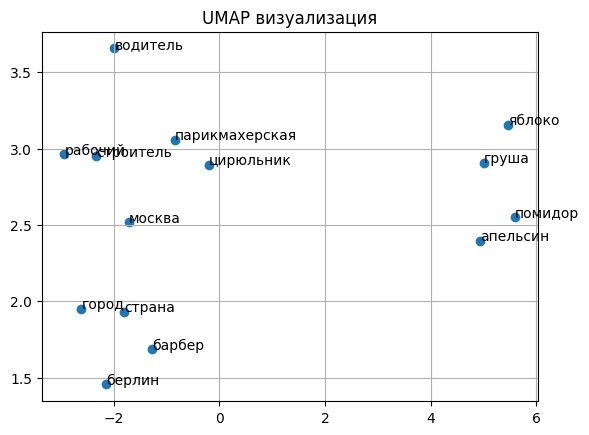

In [9]:
plt.scatter(u_spec[:,0], u_spec[:,1])

for i, txt in enumerate(spec_key):
    plt.annotate(txt, (u_spec[i, 0], u_spec[i, 1]))
plt.title('UMAP визуализация')
plt.grid()

Посмотрим как расположены выделенные нами слова на общем множестве.

In [10]:
mapper = umap.UMAP(n_components=2, metric='cosine')

u      = mapper.fit_transform(embeddings[:10_000])
u_spec = mapper.transform(spec_emb)

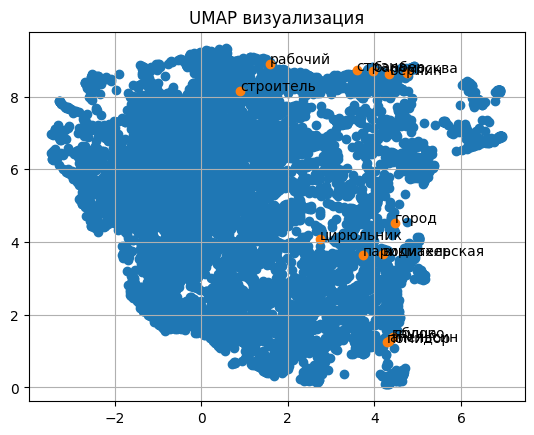

In [11]:
plt.scatter(u[:,0], u[:,1])
plt.scatter(u_spec[:,0], u_spec[:,1])

for i, txt in enumerate(spec_key):
    plt.annotate(txt, (u_spec[i, 0], u_spec[i, 1]))
plt.title('UMAP визуализация')
plt.grid()

## `Операции над эмбеддингами`

В моделях из библиотеки `gensim` реализован автоматический поиск наиболее похожих слов, то есть поиск слов, чьи эмбеддинги наиболее близки.

In [12]:
a = word2vec_rus.get_vector('холод_NOUN')

word2vec_rus.similar_by_vector(a)

[('холод_NOUN', 1.0),
 ('стужа_NOUN', 0.754147469997406),
 ('мороз_NOUN', 0.7195620536804199),
 ('сырость_NOUN', 0.6915026307106018),
 ('мерзнуть_VERB', 0.6622565984725952),
 ('тепло_NOUN', 0.6225268840789795),
 ('зябнуть_VERB', 0.6161022186279297),
 ('жара_NOUN', 0.6121419668197632),
 ('замерзать_VERB', 0.6117622256278992),
 ('знобить_VERB', 0.5948620438575745)]

Кроме того, мы можем производить над эмбеддингами арифметические операции.

In [13]:
a = word2vec_rus.get_vector('король_NOUN')
b = word2vec_rus.get_vector('мужчина_NOUN')

word2vec_rus.similar_by_vector(a - b)

[('король_NOUN', 0.6571975350379944),
 ('королевство_NOUN', 0.45206212997436523),
 ('королевский_ADJ', 0.4399426579475403),
 ('максимилианов_NOUN', 0.421102374792099),
 ('кельский_ADJ', 0.41280296444892883),
 ('каролус_NOUN', 0.4126133322715759),
 ('рагоци_NOUN', 0.40673765540122986),
 ('герцог_NOUN', 0.4043634831905365),
 ('королева_NOUN', 0.40316253900527954),
 ('дурлахский_ADJ', 0.4029974937438965)]

In [14]:
c = word2vec_rus.get_vector('женщина_NOUN')

word2vec_rus.similar_by_vector(a - b + c)

[('король_NOUN', 0.8805387616157532),
 ('королева_NOUN', 0.7313904762268066),
 ('герцог_NOUN', 0.6502388715744019),
 ('принцесса_NOUN', 0.6266285181045532),
 ('герцогиня_NOUN', 0.6240381598472595),
 ('королевство_NOUN', 0.6094207167625427),
 ('зюдерманландский_ADJ', 0.6084389686584473),
 ('дурлахский_ADJ', 0.6081665754318237),
 ('ульрик::элеонора_NOUN', 0.6073107719421387),
 ('максимилианов_NOUN', 0.6057003736495972)]

In [15]:
a = word2vec_rus.get_vector('москва_NOUN')
b = word2vec_rus.get_vector('россия_NOUN')
c = word2vec_rus.get_vector('германия_NOUN')

word2vec_rus.similar_by_vector(a - b + c)

[('берлин_NOUN', 0.7166863679885864),
 ('москва_NOUN', 0.6859816312789917),
 ('германия_NOUN', 0.6379823088645935),
 ('мюнхен_NOUN', 0.6141613721847534),
 ('гамбург_NOUN', 0.5910832285881042),
 ('дрезден_NOUN', 0.5751315951347351),
 ('бабельсберг_NOUN', 0.5680847764015198),
 ('париж_NOUN', 0.5643576979637146),
 ('лейпциг_NOUN', 0.555885910987854),
 ('карлсхорст_NOUN', 0.553295373916626)]

Чуть аккуратней этот функционал уже реализован в библиотеки.

In [16]:
word2vec_rus.most_similar(
    positive=['москва_NOUN', 'германия_NOUN'], 
    negative=['россия_NOUN']
)

[('берлин_NOUN', 0.7166863679885864),
 ('мюнхен_NOUN', 0.6141614317893982),
 ('гамбург_NOUN', 0.5910831689834595),
 ('дрезден_NOUN', 0.5751315951347351),
 ('бабельсберг_NOUN', 0.5680848360061646),
 ('париж_NOUN', 0.5643577575683594),
 ('лейпциг_NOUN', 0.555885910987854),
 ('карлсхорст_NOUN', 0.5532953143119812),
 ('билефельд_NOUN', 0.5470367074012756),
 ('дуйсбург_NOUN', 0.5449016690254211)]

У некоторых слов много значений, поэтому мы найдем достаточно разные слова по смыслу.

In [17]:
word2vec_rus.similar_by_vector('ручка_NOUN')

[('ножка_NOUN', 0.6115206480026245),
 ('рукоятка_NOUN', 0.6041494607925415),
 ('рука_NOUN', 0.562088668346405),
 ('пальчик_NOUN', 0.5414899587631226),
 ('рычажок_NOUN', 0.5311201214790344),
 ('ноготочка_NOUN', 0.5253746509552002),
 ('головка_NOUN', 0.5234273076057434),
 ('дверной_ADJ', 0.5118672251701355),
 ('щечка_NOUN', 0.508470356464386),
 ('поприседать_VERB', 0.5080488324165344)]

Кроме того, можно быстро находить синонимы.

In [18]:
word2vec_rus.similar_by_vector('красивый_ADJ')

[('красиво_ADV', 0.6824069619178772),
 ('некрасивый_ADJ', 0.6662992238998413),
 ('нарядный_ADJ', 0.6605890989303589),
 ('прекрасный_ADJ', 0.6481409668922424),
 ('элегантный_ADJ', 0.6363735795021057),
 ('красавец_NOUN', 0.6171321868896484),
 ('очаровательный_ADJ', 0.6072524189949036),
 ('прелестный_ADJ', 0.606392502784729),
 ('хорошенький_ADJ', 0.6016284823417664),
 ('изящный_ADJ', 0.6009820699691772)]

Мы ожидаем, что для разных по смыслу словам расстояние между эмбеддингами будет больше, чем между похожими.

In [19]:
word2vec_rus.distance('лето_NOUN', 'тепло_NOUN')

0.7372509837150574

In [20]:
word2vec_rus.distance('лето_NOUN', 'весна_NOUN')

0.23251086473464966

In [21]:
word2vec_rus.distance('лето_NOUN', 'осень_NOUN')

0.19974982738494873

In [22]:
word2vec_rus.distance('лето_NOUN', 'зима_NOUN')

0.1893957257270813

Однако не стоит забывать, что эмбеддинги не идеальные, поэтому иногда возникают странные ситуации.

In [23]:
word2vec_rus.distance('лето_NOUN', 'стол_NOUN')

0.8931916579604149

In [24]:
word2vec_rus.distance('лето_NOUN', 'стул_NOUN')

0.9371734037995338

В случае более эмбеддингов полученных из нейронных сетей, можно даже обучать линейные модели для поиска "смысловых компонент" слова. Подробнее можно изучить [по ссылке](https://lars76.github.io/2021/06/16/operations-contextual-embeddings.html).

## `Классификация`

Мы хотим использовать векторные представления слов для алгоритмов машинного обучения или нейронных сетей. Прежде чем перейти к нейронным сетям, нам нужны бейзлайны, то есть то, с чем будем сравниваться. Сначала проверим, как работают стандартные алгоритмы машинного обучения на эмбеддингах.

Мы будем решать задачу бинарной классификации для [датасета рецензий с Imdb](https://ai.stanford.edu/~amaas/data/sentiment/). 

В качестве базовой модели будем использовать [CatBoost](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier).

Подробный список классических датасетов для классификации текста можно посмотреть [здесь](https://lena-voita.github.io/nlp_course/text_classification.html#dataset_examples)

In [25]:
if not os.path.exists("aclImdb_v1.tar.gz"):
    ! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    ! tar -xvf aclImdb_v1.tar.gz

Мы не будем усердно заниматься предобработкой, так как наша цель — именно сравнить методы, а не добиться более высокого качества. В качестве предобработки мы приведём все символы к нижнему регистру.

In [26]:
def preprocess(l):
    return l.lower()

In [27]:
def get_dataset(split='train', base_dir='aclImdb'):
    path_data   = os.path.join(base_dir, split)
    path_data_n = os.path.join(path_data, 'neg')
    path_data_p = os.path.join(path_data, 'pos')
    path_neg  = list(os.listdir(path_data_n))
    path_neg  = sorted(path_neg)
    path_pos  = list(os.listdir(path_data_p))
    path_pos  = sorted(path_pos)
    
    
    print(f"Объектов отрицательного класса {len(path_neg)}")
    print(f"Объектов положительного класса {len(path_pos)}")
    
    X = []
    y = [0] * len(path_neg) + [1] * len(path_pos)
    
    for p in path_neg:
        with open(os.path.join(path_data_n, p), 'r') as f:
            l = f.readline()
            X.append(preprocess(l))
            
    for p in path_pos:
        with open(os.path.join(path_data_p, p), 'r') as f:
            l = f.readline()
            X.append(preprocess(l))
            
    return X, y

In [28]:
X_train, y_train = get_dataset(split='train')

Объектов отрицательного класса 12500
Объектов положительного класса 12500


In [29]:
X_test, y_test = get_dataset(split='test')

Объектов отрицательного класса 12500
Объектов положительного класса 12500


Посмотрим на примеры предложений.

In [30]:
X_train[0]

"story of a man who has unnatural feelings for a pig. starts out with a opening scene that is a terrific example of absurd comedy. a formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting. even those from the era should be turned off. the cryptic dialogue would make shakespeare seem easy to a third grader. on a technical level it's better than you might think with some good cinematography by future great vilmos zsigmond. future stars sally kirkland and frederic forrest can be seen briefly."

In [31]:
X_test[0]

"once again mr. costner has dragged out a movie for far longer than necessary. aside from the terrific sea rescue sequences, of which there are very few i just did not care about any of the characters. most of us have ghosts in the closet, and costner's character are realized early on, and then forgotten until much later, by which time i did not care. the character we should really care about is a very cocky, overconfident ashton kutcher. the problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. his only obstacle appears to be winning over costner. finally when we are well past the half way point of this stinker, costner tells us all about kutcher's ghosts. we are told why kutcher is driven to be the best with no prior inkling or foreshadowing. no magic here, it was all i could do to keep from turning it off an hour in."

Для обучения моделей эмбедингов, нам нужно разделить слова на структурные единицы (символы, слова, N-Gramm). Мы будем работать на уровне слов.

In [32]:
def get_corpus(X_data):
    
    return list(x.split() for x in X_data)

In [33]:
corpus_train = get_corpus(X_train)
corpus_test  = get_corpus(X_test)

In [34]:
corpus_train[0][:10]

['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a']

### `word2vec`

Обучим word2vec модель на наших данных.

**Важно:** Мы обучаем модель на всем корпусе текста, так как нам нужно построить словарь. Кроме того, мы решаем unsupervised задачу.

In [35]:
main_corpus = corpus_train + corpus_test

In [36]:
%%time
model_wv = gensim.models.Word2Vec(sentences=main_corpus, vector_size=100, window=5, min_count=1, workers=4)

CPU times: user 1min 40s, sys: 275 ms, total: 1min 40s
Wall time: 30 s


Эмбеддинг слова является вектором размерности 100, при этом каждое предложение имеет разную длину. Мы (пока) не умеем обучать модель на данных произвольного размера, поэтому нам нужно как-то аггрегировать эмбединги по всему предложению.

Мы будем использовать средний эмбеддинг предложения, как фичу для обучению классификатора. В таком подходе мы **не учитываем порядок слов**, то есть теряем много информации.

In [37]:
def encode_corpus(corpus, encode_fn):
    
    corp_enc = []
    for sentences in corpus:
        sent_enc = list(encode_fn(w) for w in sentences)
        sent_enc = np.array(sent_enc).mean(axis=0)

        corp_enc.append(sent_enc)
    
    return np.array(corp_enc)

In [38]:
enc_train_wv = encode_corpus(corpus_train, lambda k: model_wv.wv[k])
enc_test_wv  = encode_corpus(corpus_test,  lambda k: model_wv.wv[k])

In [39]:
from catboost import CatBoostClassifier

In [40]:
def accuracy(y_pred, y_test):
    acc = np.mean(y_pred == y_test)
    print(f"Точность {acc:0.3f}")

In [41]:
clf = CatBoostClassifier()
clf.fit(enc_train_wv, y_train, verbose=False)

In [42]:
y_pred = clf.predict(enc_test_wv)
accuracy(y_pred, y_test)

Точность 0.797


# `fasttext`

Для использования библитеки `fasstext` будем использовать специализированную [библиотеку](https://fasttext.cc/docs/en/python-module.html). Для этого нам необходимо записать наш корпус текста в файл.

In [43]:
import fasttext

In [44]:
data = X_train + X_test
data = list(d + "\n" for d in data)

In [45]:
with open("all_data.txt", "w") as f:
    f.writelines(data)

In [46]:
# Занимает 5 минут
# Progress: 100.0% words/sec/thread:   34499 lr:  0.000000 avg.loss:  2.004246 ETA:   0h 0m 0s

# %%time
# model_fasttext = fasttext.train_unsupervised(
#     "all_data.txt", 
#     model='skipgram', 
#     dim=100, 
#     epoch=10, 
#     wordNgrams=2, 
#     verbose=1
# )

In [47]:
# model_fasttext.save_model("model_fasttext.bin")
model_fasttext = fasttext.load_model("model_fasttext.bin")

In [48]:
enc_train_ft = encode_corpus(corpus_train, lambda k: model_fasttext[k])
enc_test_ft  = encode_corpus(corpus_test,  lambda k: model_fasttext[k])

In [49]:
clf = CatBoostClassifier()
clf.fit(enc_train_ft, y_train, verbose=False)

In [50]:
y_pred = clf.predict(enc_test_ft)
accuracy(y_pred, y_test)

Точность 0.878


Теперь у нас есть **два бейзлайна**: 
- `word2vec` + `CatBoost` - accuracy 0.79
- `fasttext` + `CatBoost` - accuracy 0.88

## `Нейронный подход`

В этой части мы обучим нейронные сети для классификации текстов. Мы рассмотрим, как токенизировать тексты с помощью библиотеки `tokenizers`, чтобы работа с токенами происходила независимо от архитектуры и обучения. Также мы сравним различные архитектуры для классификации, в частности, MLP и свёрточные. 

Важной частью будет сравнение результатов с подходами из классического машинного обучения.

Все логи обучения доступны [по ссылке](https://wandb.ai/3145tttt/text_classifier_mmp_2025/overview).

In [51]:
from tqdm import tqdm
from functools import partial

import wandb

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import tokenizers
from tokenizers import Tokenizer, trainers

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [52]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

In [53]:
set_global_seed(42)

### `tokenizers`

Прежде чем создавать модель, нам необходимо создать словарь и произвести токенизацию предложений. Именно от словаря будет зависеть, насколько много "слов" знает наша модель. Мы воспользуемся библиотекой [tokenizers](https://huggingface.co/docs/tokenizers/index). Библиотека `tokenizers` является частью инфраструктуры `Hugging Face`, с который вы познакомитесь на ближайших парах.



В [ноутбуке прошлого года](https://github.com/mmp-practicum-team/mmp_practicum_spring_2024/blob/main/Seminars/Seminar%2007/%D0%AF%D0%B7%D1%8B%D0%BA%D0%BE%D0%B2%D1%8B%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8.%20Torchtext.ipynb) вы можете познакомиться с [библиотекой](https://pytorch.org/text/stable/index.html). Мы её не рассматриваем, так как с апреля 2024 года она не поддерживается.


Токенезация происходит через класс `tokenizer`. Для того чтобы получить `tokenizer` его надо сначала **обучить**, для этого нам необходимо использовать `tokenizers.trainers`. Так как мы будем работать на уровне слов, то выберем `tokenizers.trainers.WordLevelTrainer`.

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

#### `WordLevelTrainer`

Для начала мы будем разбивать предложение по словам, для этого воспользуемся `trainers.WordLevelTrainer`. Будем рассматривать словарь размером 5000 слов.

```python
trainers.WordLevelTrainer(self, /, *args, **kwargs)
Docstring:     
Trainer capable of training a WorldLevel model

Args:
    vocab_size (:obj:`int`, `optional`):
        The size of the final vocabulary, including all tokens and alphabet.

    min_frequency (:obj:`int`, `optional`):
        The minimum frequency a pair should have in order to be merged.

    show_progress (:obj:`bool`, `optional`):
        Whether to show progress bars while training.

    special_tokens (:obj:`List[Union[str, AddedToken]]`):
        A list of special tokens the model should know of.
```

In [54]:
top_n_words = 5_000

In [55]:
trainer = trainers.WordLevelTrainer(
    vocab_size     = top_n_words,
    special_tokens = ["<pad>", "<unk>"],
    show_progress  = True
)

tokenizer = tokenizers.Tokenizer(
    model=tokenizers.models.WordLevel()
)

Мы будем обучаться из памяти, поэтому нам необходимо передать итератор, который пройдет по всем текстам, которые уже разбиты на слова.

In [56]:
text_data = corpus_train + corpus_test
text_data[0][:10]

['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a']

In [57]:
tokenizer.train_from_iterator(tqdm(text_data, total=len(text_data)), trainer=trainer)

100%|█████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9169.40it/s]


Посмотрим на словарь.

In [58]:
print(f"Размер словаря {tokenizer.get_vocab_size()}")

print(list(tokenizer.get_vocab().keys())[:10])

for idx in [0, 1, 2, 21, 42]:
    print(f"idx = {idx}, word = {tokenizer.id_to_token(idx)}")

Размер словаря 5000
['amateurish', 'eight', 'steps', 'previous', 'thoroughly', 'finger', 'ryan', 'gun', 'african', 'brave']
idx = 0, word = <pad>
idx = 1, word = <unk>
idx = 2, word = the
idx = 21, word = are
idx = 42, word = about


**Важно:** Cпециальные токены имеют наименьшие *id* по умолчанию.

Для кодирования предложений используется метод `encode`, так как мы самостоятельно описали функцию `tokenize`, то установим `is_pretokenized=True`

In [59]:
tokinezed_text = text_data[0][:20]

print("Исходный текст:")
print(tokinezed_text)

result = tokenizer.encode(tokinezed_text, is_pretokenized=True)
print(result)

print("Tokens ids: ", result.ids)

Исходный текст:
['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a', 'pig.', 'starts', 'out', 'with', 'a', 'opening', 'scene', 'that', 'is', 'a']
Encoding(num_tokens=20, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Tokens ids:  [77, 5, 3, 160, 36, 41, 1, 1572, 17, 3, 1, 478, 47, 16, 3, 557, 147, 11, 7, 3]


Для декодирования воспользуемся методом `decode`, мы хотим посмотреть на сколько словарь из 5 тысяч слов выразительный, то есть какие слова мы пропускаем и понятен ли смысл предложение без них.

In [60]:
print("Исходный текст:")
print(tokinezed_text)

print("Результат декодирования:")
print(tokenizer.decode(result.ids, skip_special_tokens=False))

Исходный текст:
['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a', 'pig.', 'starts', 'out', 'with', 'a', 'opening', 'scene', 'that', 'is', 'a']
Результат декодирования:
story of a man who has <unk> feelings for a <unk> starts out with a opening scene that is a


В примере выше мы видим, что в нашем словаре нет слова `unnatural` и слова `pig.`. Возможно, если бы мы лучше предобратали наш текст, то таких проблем не возникло бы.

### `Данные`

#### `Датасет`

В библиотеке `Hugging Face` существуют различные модули, которые помогают оборачивать токенизаторы в удобные датасеты. Такой подход позволяет описать обучение сложных моделей в 5-10 строчек кода. В этом ноутбуке мы не сами опишем работу с данными. 

Часто бывает полезно ограничить длину предложений параметром `max_len`, чтобы подавать в модель не слишком длинные тексты.

In [61]:
class TextDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=20):
        super().__init__()
        
        self.max_len   = max_len
        self.texts     = texts
        self.targets   = targets
        self.tokenizer = tokenizer
        self.tokens    = []
        
        for text in tqdm(texts):
            tokens = self.tokenizer.encode(text, is_pretokenized=True).ids
            self.tokens.append(tokens)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
       
        tokens = self.tokens[idx]
        tokens = tokens[:self.max_len] 
        
        return {
            'text': self.texts[idx],
            'target': torch.tensor(self.targets[idx], dtype=torch.long),
            'tokens': torch.tensor(tokens, dtype=torch.long),
            'tokens_len': torch.tensor(len(tokens), dtype=torch.long),
        }
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.targets)

In [62]:
train_dataset = TextDataset(corpus_train, y_train, tokenizer)

100%|█████████████████████████████████████████████| 25000/25000 [00:08<00:00, 3043.84it/s]


Посмотрим на данные.

In [63]:
train_dataset[0]

{'text': ['story',
  'of',
  'a',
  'man',
  'who',
  'has',
  'unnatural',
  'feelings',
  'for',
  'a',
  'pig.',
  'starts',
  'out',
  'with',
  'a',
  'opening',
  'scene',
  'that',
  'is',
  'a',
  'terrific',
  'example',
  'of',
  'absurd',
  'comedy.',
  'a',
  'formal',
  'orchestra',
  'audience',
  'is',
  'turned',
  'into',
  'an',
  'insane,',
  'violent',
  'mob',
  'by',
  'the',
  'crazy',
  'chantings',
  'of',
  "it's",
  'singers.',
  'unfortunately',
  'it',
  'stays',
  'absurd',
  'the',
  'whole',
  'time',
  'with',
  'no',
  'general',
  'narrative',
  'eventually',
  'making',
  'it',
  'just',
  'too',
  'off',
  'putting.',
  'even',
  'those',
  'from',
  'the',
  'era',
  'should',
  'be',
  'turned',
  'off.',
  'the',
  'cryptic',
  'dialogue',
  'would',
  'make',
  'shakespeare',
  'seem',
  'easy',
  'to',
  'a',
  'third',
  'grader.',
  'on',
  'a',
  'technical',
  'level',
  "it's",
  'better',
  'than',
  'you',
  'might',
  'think',
  'with',

In [64]:
train_dataset[-1]

{'text': ['working-class',
  'romantic',
  'drama',
  'from',
  'director',
  'martin',
  'ritt',
  'is',
  'as',
  'unbelievable',
  'as',
  'they',
  'come,',
  'yet',
  'there',
  'are',
  'moments',
  'of',
  'pleasure',
  'due',
  'mostly',
  'to',
  'the',
  'charisma',
  'of',
  'stars',
  'jane',
  'fonda',
  'and',
  'robert',
  'de',
  'niro',
  '(both',
  'terrific).',
  "she's",
  'a',
  'widow',
  'who',
  "can't",
  'move',
  'on,',
  "he's",
  'illiterate',
  'and',
  'a',
  'closet-inventor--you',
  'can',
  'probably',
  'guess',
  'the',
  'rest.',
  'adaptation',
  'of',
  'pat',
  "barker's",
  'novel',
  '"union',
  'street"',
  '(a',
  'better',
  'title!)',
  'is',
  'so',
  'laid-back',
  'it',
  'verges',
  'on',
  'bland,',
  'and',
  'the',
  "film's",
  'editing',
  'is',
  'a',
  'mess,',
  'but',
  "it's",
  'still',
  'pleasant;',
  'a',
  'rosy-hued',
  'blue-collar',
  'fantasy.',
  'there',
  'are',
  'no',
  'overtures',
  'to',
  'serious',
  'issues

#### `Даталоадер`

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` - число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [65]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=True, padding_value=-1)

tensor([[ 1,  2,  3, -1],
        [ 4,  5, -1, -1],
        [ 6,  7,  8,  9]])

In [66]:
def collate_fn(batch, padding_value, batch_first=True):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' to rch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """

    texts       = [obj['text'] for obj in batch]
    targets     = torch.stack([obj['target'] for obj in batch])
    tokens_lens = torch.stack([obj['tokens_len'] for obj in batch])
    tokens      = torch.nn.utils.rnn.pad_sequence(
        [obj['tokens'] for obj in batch], batch_first=batch_first, padding_value=padding_value
    )
    
    return {
        'targets': targets,
        
        'texts': texts,
        'tokens': tokens,
        'tokens_lens': tokens_lens
    }

In [67]:
train_dataloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)

Посмотрим на какой-нибудь батч:

In [68]:
batch = next(iter(train_dataloader))
batch.keys(), batch['targets'], batch['tokens'], batch['tokens_lens']

(dict_keys(['targets', 'texts', 'tokens', 'tokens_lens']),
 tensor([1, 0, 1, 1]),
 tensor([[  30,    5,    2,  225,   87, 4722,    5,    2,    1,    9,   14, 1599,
           183,  175,    2,   88,   84,    9,  199,   10],
         [  10,  132,   14,  363, 1736,   17,   30,  755,  205,  790,    4,   22,
           399,   21,    1,  107,    1,   27,   82, 4706],
         [   6,   28, 3448,    9,   62,   60,  318,   48,   10,   20,   14,   42,
            50,    9,  620,  112,  188,   78,    9,  109],
         [   9, 2073,  548,   10,  380,  183, 1158,  134, 1478,    1,   19,    3,
          3310,    1,  203,   12,   14,  509,    3, 1057]]),
 tensor([20, 20, 20, 20]))

### `Эмбеддинги в PyTorch`

В случае обучение нейронной сети мы будем сами обучать эмбеддинги токенов. Для этого нам нужно использовать класс `torch.nn.Embedding`, который по сути реализует массив. 

Эмбеддинг токена $i$ это строка $i$ в матрице эмбеддингов. 

- `num_embeddings` - число токенов

- `embedding_dim` - размерность эмбеддинга

- `padding_idx` - индекс токена `<pad>`

```python
torch.nn.Embedding(
    num_embeddings: int,
    embedding_dim: int,
    padding_idx: Optional[int] = None,
    max_norm: Optional[float] = None,
    norm_type: float = 2.0,
    scale_grad_by_freq: bool = False,
    sparse: bool = False,
    _weight: Optional[torch.Tensor] = None,
    _freeze: bool = False,
    device=None,
    dtype=None,
) -> None
```

Посмотрим как преобразуется батч после слоя `nn.Embedding`.

In [69]:
embed_dim = 128

emb_layer = torch.nn.Embedding(
    tokenizer.get_vocab_size(), embed_dim, 
    padding_idx=tokenizer.token_to_id('<pad>')
)

In [70]:
out = emb_layer(batch['tokens'])

out.shape

torch.Size([4, 20, 128])

Так как `nn.Embedding` реализует матрицу, то число параметров зависит от размера словаря и размерности эмеддингов.

In [71]:
tokenizer.get_vocab_size() * embed_dim

640000

In [72]:
print_params_count(emb_layer)

Информация о числе параметров модели: Embedding
Всего параметров: 		 640000
Всего обучаемых параметров: 	 640000



### `Нейронная сеть (MLP)`

В этой части мы обучим классификатор текстов на основе полносвязной нейронной сети. Выше мы уже создали удобные класс-обёртки для работы с данными. Теперь мы соберем модель для решения задачи классификации.

In [73]:
class MLPClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, tokenizer: Tokenizer,
        dropout=0.5
    ):
        super().__init__()

        self.dropout = dropout
        
        self.tokenizer = tokenizer
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding.
        self.word_embeddings = torch.nn.Embedding(
            self.tokenizer.get_vocab_size(), self.embedding_dim, 
            padding_idx=self.tokenizer.token_to_id('<pad>')
        )
        
        self.features = torch.nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            nn.ReLU(), nn.Dropout1d(self.dropout),
            nn.Linear(self.hidden_dim,    self.hidden_dim),
            nn.ReLU(), nn.Dropout1d(self.dropout),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(), nn.Dropout1d(self.dropout),
        )
        # Create linear layer for classification
        self.output = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, self.output_size),
        )
    
    def forward(self, tokens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        embedding = self.word_embeddings(tokens)
        
        # Make forward pass through MLP network
        h   = embedding.mean(axis=1)
        h   = self.features(h)
        out = self.output(h)
        
        return out

In [74]:
net = MLPClassifier(
    embedding_dim = 128, 
    hidden_dim    = 64, 
    output_size   = 2, 
    tokenizer     = tokenizer
)

out = net(batch['tokens'])
out.shape

torch.Size([4, 2])

In [75]:
print_params_count(net)

Информация о числе параметров модели: MLPClassifier
Всего параметров: 		 656706
Всего обучаемых параметров: 	 656706



### `Цикл обучение`

In [76]:
set_global_seed(42)

device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda:0'
device

'cuda:0'

Мы описали датасет, даталоадер, архитектуру, следовательно можем переходить к циклу обучения. Мы решаем задачу классификации, поэтому будем использовать `nn.CrossEntropyLoss`

In [77]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

Для обучения мы будем брать `max_len=100`, то есть оценивать рецензию по первым 100 словам.

In [78]:
max_len    = 100
batch_size = 128
lr         = 3 * 1e-3

embedding_dim = 128
hidden_dim    = 256
output_size   = 2

In [79]:
train_dataset = TextDataset(corpus_train, y_train, tokenizer, max_len=max_len)
test_dataset  = TextDataset(corpus_test , y_train, tokenizer, max_len=max_len)

100%|█████████████████████████████████████████████| 25000/25000 [00:08<00:00, 3040.31it/s]


In [80]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True,
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)

In [81]:
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True,
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)

Модель мы определили выше, для оптимизации будем использовать `Adam`.

In [82]:
set_global_seed(42)

net = MLPClassifier(
    embedding_dim = embedding_dim, 
    hidden_dim    = hidden_dim, 
    output_size   = output_size, 
    tokenizer     = tokenizer
)

In [83]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

Цикл обучения возьмем с прошлой пары про `train loop`, поменяем только распаковку батча. В целом, хороший цикл обучения должен быть универсальным для разных задач.

In [84]:
@torch.no_grad()
def evaluate(net, valid_dataloader, loss_fn, device):
    
    net.eval()
    loss, accuracy = 0, 0
    count = 0
    for batch in valid_dataloader:
        X_batch = batch['tokens'].to(device)
        y_true  = batch['targets'].to(device)

        out = net(X_batch)
        y_pred = torch.argmax(out, 1)
        
        bs = out.shape[0]
        loss     += loss_fn(out, y_true).item() * bs
        accuracy += torch.sum(y_pred == y_true).item()
        count    += bs
        
    return loss / count, accuracy / count

    

def train_wandb_eval(epoch_num, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device, run_name):
    
    wandb.init(
        project="text_classifier_mmp_2025", 
        name=run_name,
    )
    
    global_step = 0
    net = net.to(device)
    
    for _ in tqdm(range(epoch_num)):
        net.train()
        
        for batch in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = batch['tokens'].to(device)
            y_true  = batch['targets'].to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            
            wandb.log({"train/loss": loss.item(), "train/accuracy": accuracy.item()}, step=global_step)
            
            global_step += 1
        
        loss, accuracy = evaluate(
            net              = net, 
            valid_dataloader = valid_dataloader, 
            loss_fn          = loss_fn, 
            device           = device
            )
        wandb.log({"eval/loss": loss, "eval/accuracy": accuracy}, step=global_step)
        
    wandb.finish()

In [85]:
train_wandb_eval(
    epoch_num        = 100, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = test_dataloader, 
    device           = device, 
    run_name         = "MLP_classifier"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 3145tttt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


eval/accuracy,▃▆▇██▇█▇▇▇▇▇▆▆▆▆▅▆▆▅▅▅▆▆▅▅▂▆▁▄▃▄▄▄▂▃▃▃▄▃
eval/loss,█▇▆▅▅▄▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁
train/accuracy,█▆▃▂▂▅▅▃▅▆▃▃▅▃▂▄▆▇▄▅▂▁█▅▅▃▄▅▃▃▇▂▄▄▆▄▄▃▄▆
train/loss,███▄▅▅▇█▇▆▅▃▆▄▆▅▄▅▅▅▅▆▅▆▅▅▁▃▆▅▄▄▅▃▃▅▂▅▃▄
eval/accuracy,0.77031
eval/loss,0.47487
train/accuracy,0.53906
train/loss,0.61822


Теперь мы можем пополнить нашу таблицу результатов:

- `word2vec` + `CatBoost` - accuracy 0.79
- `fasttext` + `CatBoost` - accuracy 0.88
- `nn.Embedding` + `MLP`  - accuracy (test) 0.79, accuracy (train) ~ 0.55

Важно отметить, что даже на обучении мы не смогли выбить качество выше 0.70, то есть модель недостаточно выразительна.

**Вопрос:** Как можно повысить качество?

### `Нейронная сеть (CNN)`

Попробуем еще раз посмотреть, что мы именно мы делаем

Общий вид архитектуры:
    
- Переводим токены в вектора фиксированного размера (эмбеддинги)
- Стакаем вектора в матрицу
- Извлекаем признаки из матрицы
- Подаем признаки в логистическую регрессию

Выше мы извлекали признаки не из всей матрицы, а сначала усредняли вдоль строк.

**Вопроc:** Зачем мы усредняли матрицу?

**Вопроc:** Какие способы извлечения признаков из матрицы вы знаете?

Мы можем использовать сверточные архитектуры, только с одной **оговоркой**: мы извлекаем признаки из матрицы, а не из тензора (изображения). Имеено поэтому мы будем использовать `nn.Conv1d` и действовать сверткой вдоль строк (каждая строка отвечает за эмбеддинг своего токена).

**Вопрос:** Что позволяют учитывать свертки?




In [86]:
embed_dim = 128

emb_layer = torch.nn.Embedding(
    tokenizer.get_vocab_size(), embed_dim, 
    padding_idx=tokenizer.token_to_id('<pad>')
)

embds = emb_layer(batch['tokens'])
embds.shape

torch.Size([4, 20, 128])

Мы хотим подействовать на строки, поэтому нам нужно транспонировать матрицу эмбеддингов.



In [87]:
embds = embds.transpose(1, 2)
embds.shape

torch.Size([4, 128, 20])

In [88]:
conv_layer = nn.Conv1d(128, 32, kernel_size=3)

out = conv_layer(embds)
out.shape

torch.Size([4, 32, 18])

**Вопрос:** Почему последняя размерность стала 18? Какой информацию хранят новые признаки?

К сожалению, к нам приходят предложения разной длины, но  мы хотим уметь работать с предложениями произвольной длины.

**Вопрос:** Как мы обрабатывали изображения произвольного размера? Как надо модифицировать архитектуру?

In [89]:
avg_pool_global = nn.AdaptiveAvgPool1d(output_size=1)

out_pool = avg_pool_global(out)
out_pool.shape

torch.Size([4, 32, 1])

На основе этой идеи построим модель.

In [90]:
class CNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, tokenizer: Tokenizer,
        dropout=0.5
    ):
        super().__init__()

        self.dropout = dropout
        
        self.tokenizer = tokenizer
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding.
        self.word_embeddings = torch.nn.Embedding(
            self.tokenizer.get_vocab_size(), self.embedding_dim, 
            padding_idx=self.tokenizer.token_to_id('<pad>')
        )
        
        self.features = torch.nn.Sequential(
            nn.Conv1d(self.embedding_dim, self.hidden_dim, 3), # Поменяли
            nn.ReLU(), nn.Dropout1d(self.dropout),
            nn.Conv1d(self.hidden_dim,    self.hidden_dim, 3), # Поменяли
            nn.ReLU(), nn.Dropout1d(self.dropout),
            nn.AdaptiveAvgPool1d(output_size=1),               # Поменяли
            nn.Flatten(start_dim=1)                            # Поменяли
        )
        # Create linear layer for classification
        self.output = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, self.output_size),
        )
    
    def forward(self, tokens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        embedding = self.word_embeddings(tokens)
        
        # Make forward pass through CNN network
        h   = embedding.transpose(1, 2)                        # Поменяли
        h   = self.features(h)
        out = self.output(h)
        
        return out

In [91]:
net = CNNClassifier(
    embedding_dim = 128, 
    hidden_dim    = 64, 
    output_size   = 2, 
    tokenizer     = tokenizer
)

out = net(batch['tokens'])
out.shape

torch.Size([4, 2])

In [92]:
print_params_count(net)

Информация о числе параметров модели: CNNClassifier
Всего параметров: 		 677122
Всего обучаемых параметров: 	 677122



### `Обучение CNN`

В случае сверточных нейронных сетей мы можем достаточно быстро переобучиться, поэтому уменьшим число параметров модели.

In [93]:
max_len    = 100
batch_size = 128
lr         = 3 * 1e-3

embedding_dim = 32
hidden_dim    = 16
output_size   = 2

In [94]:
set_global_seed(42)

In [95]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True,
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)

In [96]:
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True,
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)

In [97]:
set_global_seed(42)

net = CNNClassifier(
    embedding_dim = embedding_dim, 
    hidden_dim    = hidden_dim, 
    output_size   = output_size, 
    tokenizer     = tokenizer
)

In [98]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [99]:
train_wandb_eval(
    epoch_num        = 100,
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = test_dataloader, 
    device           = device, 
    run_name         = "CNN_classifier"
)

100%|███████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


eval/accuracy,▁▇███▇▇▇▇▇▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃
eval/loss,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
train/accuracy,▁▃▄▄▅▄▆▄▄▇▆▆▆▅▇▆▆▇█▇█▇▇▇▇█▇▇█▇▆▇█▇███▇▇▇
train/loss,█▆▆▄▆▄▅▆▅▄▄▅▃▄▃▂▃▃▃▃▂▃▃▂▁▂▂▁▂▁▂▂▃▁▁▂▁▁▄▂
eval/accuracy,0.72416
eval/loss,1.60639
train/accuracy,0.94531
train/loss,0.12998


При обучении нейронных сетей на маленьких выборках можно очень просто переобучить модель. Заметим, что на train мы смогли добиться почти идеального качества, значит, модель извлекает достаточно информации о выборке.

Мы бы могли повысить качество и уменьшить переобучение следующим образом:

- Взять в качестве инициализации эмбеддингов FastText.
- Добавить больше регуляризации для обучения.
- Использовать более умную токенизацию.
- Лучше предобработать текст.


Однако при прочих равных на нашем игрушечном эксперименте получились следующие результаты:
    

- `word2vec` + `CatBoost` - accuracy 0.79
- `fasttext` + `CatBoost` - accuracy 0.88
- `nn.Embedding` + `MLP`  - accuracy (test) 0.79, accuracy (train) ~ 0.55
- `nn.Embedding` + `CNN`  - accuracy (test) 0.80, accuracy (train) ~ 0.95

**Вопрос:** Какие смысловые проблемы вы видете в сверточных сетях?

## `Выводы`

- Словарь отражает ваше знание о задаче, вы можете заложить некоторый `Inductive bias` в словарь. Например, если у вас задача генерации молекул, то можно создать словарь из которого гарантировано будут получаться хорошие молекулы (синтетически доступные).
- Использовать стандартные приёмы для получения эмбеддингов бывает полезно как в качестве **теоретического бейзлайна**, так и на **практике**.
- Можно задавать различные архитектуры: полносвязные, сверточные.
- Мы пока не научились учитывать контекст произвольной длины.